Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных 
предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 
1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения
и как?

In [83]:
# импортирую необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

In [84]:
df = pd.read_csv("/home/jupyter-e.gorchakova-16/финальный проект/Проект_1_Задание_2.csv", sep=";")

In [85]:
df.head()

user_id  revenue testgroup
0        1        0         b
1        2        0         a
2        3        0         a
3        4        0         b
4        5        0         b

In [86]:
# проверяю пропущенные значения
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [87]:
# проверяю наличие  дубликатов
df.loc[df.duplicated()]

Empty DataFrame
Columns: [user_id, revenue, testgroup]
Index: []

In [88]:
# разделяю исходный датафрейм на 2 группы, чтобы проанализировать данные в каждой группе
df_a = df[df.testgroup == "a"]

In [89]:
df_a.shape

(202103, 3)

In [90]:
df_b = df[df.testgroup == "b"]

In [91]:
# количество пользователей в обеих группах практически одинаковое
df_b.shape

(202667, 3)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


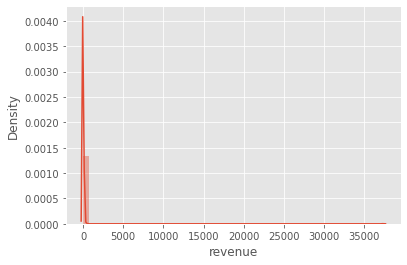

In [92]:
ax = sns.distplot(df_a.revenue)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


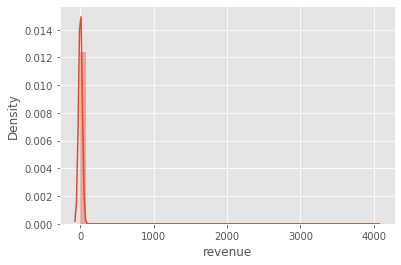

In [93]:
ax = sns.distplot(df_b.revenue)

In [94]:
# отделяю когорту платящих пользователей, смотрю данные по ним
clients_a = df_a[df_a.revenue > 0]

In [95]:
clients_a.shape

(1928, 3)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


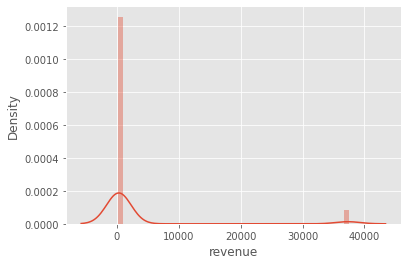

In [96]:
ax = sns.distplot(clients_a.revenue)

In [97]:
# видим, что медиана выручки в этой группе 311, есть  какое-то  кол-во крупных покупок 
# (оно-менее 25% от общего кол-ва покупок)
clients_a.revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [98]:
# видим , что в группе а - 123 покупки из 1928 очень крупные (>37000)
clients_a[clients_a.revenue > 400].sort_values("revenue")

user_id  revenue testgroup
19495     19496    37293         a
81477     81478    37294         a
235858   235859    37294         a
254113   254114    37294         a
34534     34535    37294         a
...         ...      ...       ...
142804   142805    37379         a
21585     21586    37385         a
65077     65078    37394         a
196601   196602    37407         a
101861   101862    37433         a

[123 rows x 3 columns]

In [99]:
clients_a[clients_a.revenue > 400].revenue.sum()

4590252

In [100]:
# оцениваю данные платящих пользователей в группе b
clients_b = df_b[df_b.revenue > 0]

In [101]:
clients_b.shape

(1805, 3)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


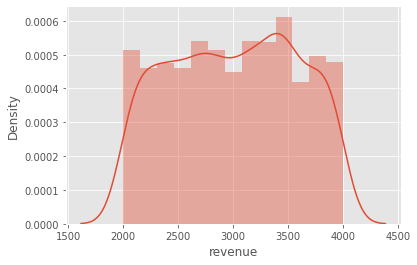

In [102]:
ax = sns.distplot(clients_b.revenue)

In [103]:
# видим, что выбросов с сторону низких или высоких значений нет- пользователли плятят от 2000 до 4000.
clients_b.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

In [104]:
# подсчитаю общую выручку в 2 группах
clients_a.revenue.sum()

5136189

In [105]:
clients_b.revenue.sum()

5421603

In [106]:
# подсчитаю ARPU в каждой группе:
ARPU_a = df_a.revenue.mean().round(2)

In [107]:
ARPU_b = df_b.revenue.mean().round(2)

In [108]:
ARPU_diff = round((ARPU_b - ARPU_a) / ARPU_a * 100, 2)

In [109]:
ARPU_a

25.41

In [110]:
ARPU_b

26.75

In [111]:
ARPU_diff

5.27

In [112]:
# видно, что в группе b на 5% ARPU  больше, проверим значимость разницы при помощи бутстрапа, т.к распределение 
# ненормальное, с выбросами 
# Нулевая гипотеза: различий между группами а и б нет
def get_bootstrap(col1, col2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    """
        col1: значения первой выборки
        col2: значения второй выборки
        boot_it: количество бутстрап-подвыборок
        statistic: интересующая статистика
        bootstrap_conf_level: уровень значимости
    """
    boot_len = max(len(col1), len(col2))
    boot_data = []
    # извлекаем подвыборки
    for i in range(boot_it):
        samples_1 = col1.sample(boot_len, replace=True).values
        samples_2 = col2.sample(boot_len, replace=True).values
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    p_1 = stats.norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = stats.norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # рисуем гистограмму
    plt.hist(pd_boot_data[0], bins=50)
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    return {"boot_data": boot_data, "ci": ci, "p_value": p_value}

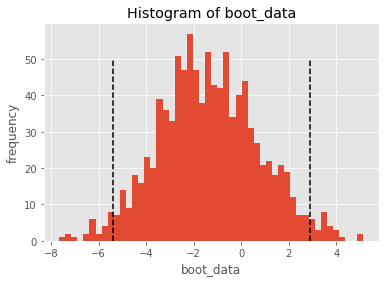

In [113]:
booted_data_ARPU = get_bootstrap(df_a.revenue, df_b.revenue)

In [114]:
booted_data_ARPU["p_value"]

0.5164279067830815

In [115]:
booted_data_ARPU["ci"]

0
0.025 -5.388248
0.975  2.878278

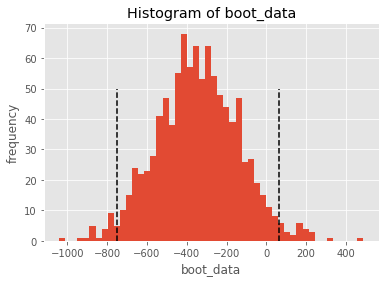

In [116]:
# так доля платящих пользователей мала в каждой группе (примерно 0.01 %), 
# то оценю ARPU только среди платящих пользователей, чтобы избежать зашумления данных неплатящими пользователями
booted_data_ARPU_clients = get_bootstrap(clients_a.revenue, clients_b.revenue)

In [117]:
booted_data_ARPU_clients["p_value"]

0.09501399990330896

In [118]:
# ARPPU - средний доход с платящего пользователя: 
clients_a.revenue.mean()

2663.9984439834025

In [119]:
clients_b.revenue.mean()

3003.6581717451522

In [120]:
clients_b.revenue.mean() - clients_a.revenue.mean()

339.65972776174976

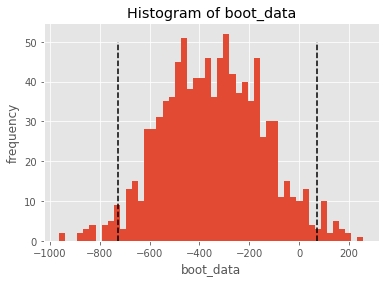

In [121]:
booted_data_ARPPU = get_bootstrap(clients_a.revenue, clients_b.revenue)

In [122]:
booted_data_ARPPU["p_value"]

0.08792369328845004

In [123]:
booted_data_ARPPU["ci"]

0
0.025 -728.770941
0.975   71.425233

In [124]:
# Проведем оценку конверсии в 2 группах через хи-квадрат Пирсона:
conversion_a = round(clients_a.shape[0] / df_a.shape[0] * 100, 2)

In [125]:
conversion_a

0.95

In [126]:
conversion_b = round(clients_b.shape[0] / df_b.shape[0] * 100, 2)

In [127]:
conversion_b

0.89

In [128]:
round(conversion_a - conversion_b, 2)

0.06

In [129]:
# переназначим переменные для применения хи квадрата
clients_a = clients_a.shape[0]
clients_b = clients_b.shape[0]
df_a = df_a.shape[0]
df_b = df_b.shape[0]

In [130]:
stat, p, dof, expected = stats.chi2_contingency([[clients_a, clients_b], [df_a, df_b]])

In [131]:
# получили з =0.038, значит , разница между конверсией в 2 группах статистически различается. В группе а больше.
p, dof

(0.03824373651044171, 1)

### получили следующие данные:
### a- 1929 покупателей, из которых 123 сделали очень крупные покупки,           общая выручка 5136189 
### (большая часть прибыли за счет крупных покупок)
### b- 1805 покупателей, суммы покупок равномерно распределены от 2 до 4 тысяч,  общая выручка 5421603
### ARPU: в группе b  больше на 5%, но нельзя отклонить гипотезу о том, что это случайность
### ARPPU: в группе b выше на 340, но нельзя отклонить гипотезу, что это случайность
### конверсия: в группе а выше на 0,06, изменения стат.значимы

### Вывод: Полученные данные противоречивы, раскатывать какую- либо версию акционных предложений на всю аудиторию рано. 
### Возможно, стоит запросить большее кол-во данных, чтобы получить стат.значимые изменения метрик.